# UFC Pay-Per-View Analysis

Over the past few years, I've become more and more of a fan of mixed martial arts and the UFC. From devestating knockout punches to devestating chokeholds to devestating arm bars, there's just a certain thrill in watching two people beat each other close to death. As one UFC commentator describes the sport, MMA is simply "high level problem-solving with dire physical consequences".

It's just a curious fact that violence brings folks together. When big fights come around, viewing parties at bars and homes around the world have people tuning in to watch their favourite fighters compete. As a business, the UFC relies on selling Pay-Per-View access to watch their main events. This puts pressure to organize on the company to orchestrate the most exciting fight cards possible - and this excitement is dictated by the talent and charisma of the UFC's fighters.

In this exploratory analysis, my goal is to examine how the UFC's PPV sales have changed over time. Is the UFC selling more PPVs now than in the past? Which fighters bring in the most PPV buys, and how is the UFC promoting events with this in mind? How dependent is the UFC on "superstars" to keep itself growing? I'm going to focus the past 10 years of numbered UFC events (excluding smaller Ultimate Fighter and Fight Night events), dating all the way back to UFC 80 on January 19th, 2008.

This dataset was made by scraping information from the infoboxes on each event's Wikipedia page and PPV data from Tapology.com; it is publically available for anyone to download/analyze at this link: _____.

## Imports and Load Data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
sns.set_style("darkgrid")
import re
import datetime as dt

pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
mpl.rcParams['figure.figsize'] = (16.0, 10.0) # default plotting dimensions

In [3]:
data = pd.read_csv("data/ufc_clean2.csv")
data = data.set_index(pd.DatetimeIndex(data['Date']))
data.drop(['Date', 'Promotion'], axis=1, inplace=True)
data.head()

,Event,Title,Fighter_1,Fighter_2,Rematch,Venue,City,Attendance,Gate,Buyrate
Date,,,,,,,,,,
1993-11-12,UFC 1,The Beginning,NaN,NaN,0,McNichols Sports Arena,"Denver, Colorado",7800.000,nan,86000.000
1994-03-11,UFC 2,No Way Out,NaN,NaN,0,Mammoth Gardens,"Denver, Colorado",2000.000,nan,300000.000
1994-09-09,UFC 3,The American Dream,NaN,NaN,0,Grady Cole Center,"Charlotte, North Carolina",3000.000,nan,90000.000
1994-12-16,UFC 4,Revenge of the Warriors,NaN,NaN,0,Expo Square Pavilion,"Tulsa, Oklahoma",5857.000,nan,120000.000
1995-04-07,UFC 5,Gracie vs. Shamrock 2,Gracie,Shamrock,1,Independence Arena,"Charlotte, North Carolina",6000.000,nan,260000.000


# Buyrate Analysis of UFC Main Events

In [4]:
ufc10 = data['2008':dt.date.today()] # at time of writing last event was 229
print(len(ufc10))
ufc10.head()

148


,Event,Title,Fighter_1,Fighter_2,Rematch,Venue,City,Attendance,Gate,Buyrate
Date,,,,,,,,,,
2008-01-19,UFC 80,Rapid Fire,NaN,NaN,0,Metro Radio Arena,"Newcastle, United Kingdom",8412.000,1250000.000,225000.000
2008-02-02,UFC 81,Breaking Point,NaN,NaN,0,Mandalay Bay Events Center,"Las Vegas, Nevada",10583.000,2437890.000,600000.000
2008-03-01,UFC 82,Pride of a Champion,NaN,NaN,0,Nationwide Arena,"Columbus, Ohio",16431.000,2200000.000,325000.000
2008-04-19,UFC 83,Serra vs. St-Pierre 2,Serra,St-Pierre,1,Bell Centre,"Montreal, Quebec, Canada",21390.000,5100000.000,530000.000
2008-05-24,UFC 84,Ill Will,NaN,NaN,0,MGM Grand Garden Arena,"Las Vegas, Nevada",14773.000,3732000.000,475000.000


In [5]:
# ufc 100
ufc10.at['2009-07-11', 'Title'] = 'UFC 100'

# UFC 229 PPV estimate
#ufc10.at['2018-10-06', 'Buyrate'] = 2400000

# seperating the diaz bros
ufc10.at['2011-10-29', 'Fighter_2'] = 'Nick Diaz'
ufc10.at['2012-02-04', 'Fighter_1'] = 'Nick Diaz'
ufc10.at['2013-03-16', 'Fighter_2'] = 'Nick Diaz'
ufc10.at['2015-01-31', 'Fighter_2'] = 'Nick Diaz'

ufc10.at['2016-03-05', 'Fighter_2'] = 'Nate Diaz'
ufc10.at['2016-08-20', 'Fighter_1'] = 'Nate Diaz'

# separating silva fighters
ufc10.at['2010-01-02', 'Fighter_2'] = 'Thiago Silva'
ufc10.at['2012-06-23', 'Fighter_2'] = 'Wanderlei Silva'


/home/will/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Impute missing Buyrate data

I'm going to fill in missing buyrates with the median for their year - these will ignore any outliers that would pull down or up an average.

In [6]:
median_yearly_buy = ufc10.resample('Y')['Buyrate'].median()
years = median_yearly_buy.index.year
median_yearly_buy.index = years
median_yearly_buy

Date
2008   505000.000
2009   500000.000
2010   520000.000
2011   332500.000
2012   410000.000
2013   380000.000
2014   222500.000
2015   600000.000
2016   322000.000
2017   265000.000
2018   280000.000
Name: Buyrate, dtype: float64

In [7]:
null_ix = ufc10[ufc10['Buyrate'].isnull()]['Buyrate'].index

for i in null_ix:
    ufc10.at[i, 'Buyrate'] = median_yearly_buy[i.year]

### Yearly Buyrate

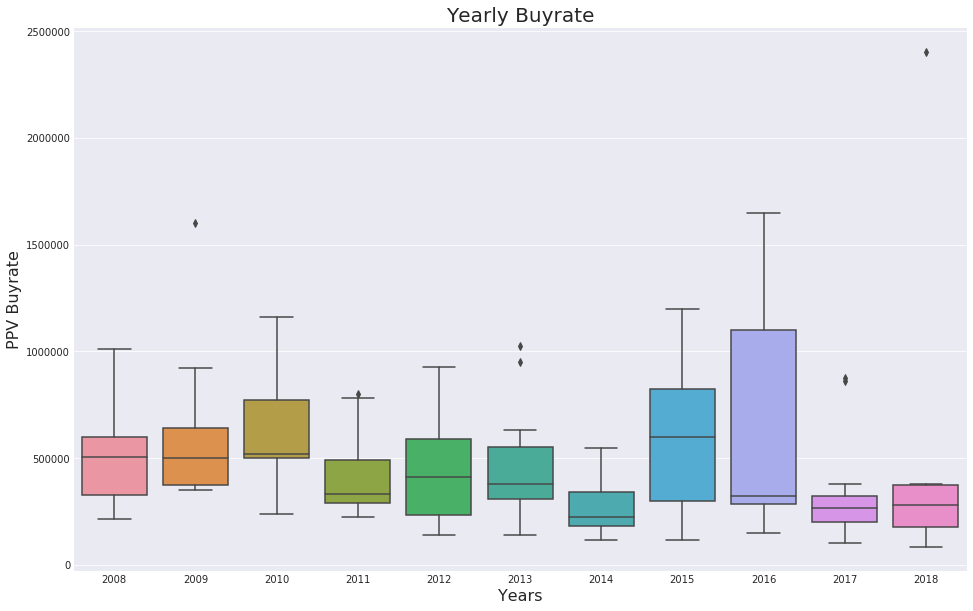

In [8]:
sns.boxplot(x= ufc10.index.year, y=ufc10['Buyrate'],)
plt.title('Yearly Buyrate', fontsize=20)
plt.ylabel('PPV Buyrate', fontsize=16)
plt.xlabel("Years", fontsize=16)

plt.savefig("images/0.png")


This is a boxplot visualizing the yearly distributions of PPV buyrates from 2008 - 2018. For those who aren't privy to how boxplots represent data, this diagram shows you all you need to know:

PIC

Between 2008 and 2010, the median PPV buyrate was hovering closely around 500,000. PPV performance in these years seems pretty consistent, with each year having events that crack more than 1M PPV buys. From 2011 to 2014, the buyrate begins to slide down, culminating in its weakest median ever at 222,500 in 2014. During this period it appears that the UFC's appeal was slowly drifting to low performance (evidenced by the slowly tightening upper whiskers on the box plots); this all changes when the median buyrate skyrockets to its highest ever at 600,000 in 2015.

2015 in my mind marks the beginning of a new era for the UFC, which defined by a clear dependance on a small number of superstar fighters (but mainly Conor McGregor). The volatility of this is clearly evident: after a strong 2015 and 2016, the buyrate loses most of its steam save for two massive outliers (the MayMac money fight in 2017 and UFC 229). More on Conor McGregor's impact to come.

### Cumulative PPV Buys per Year

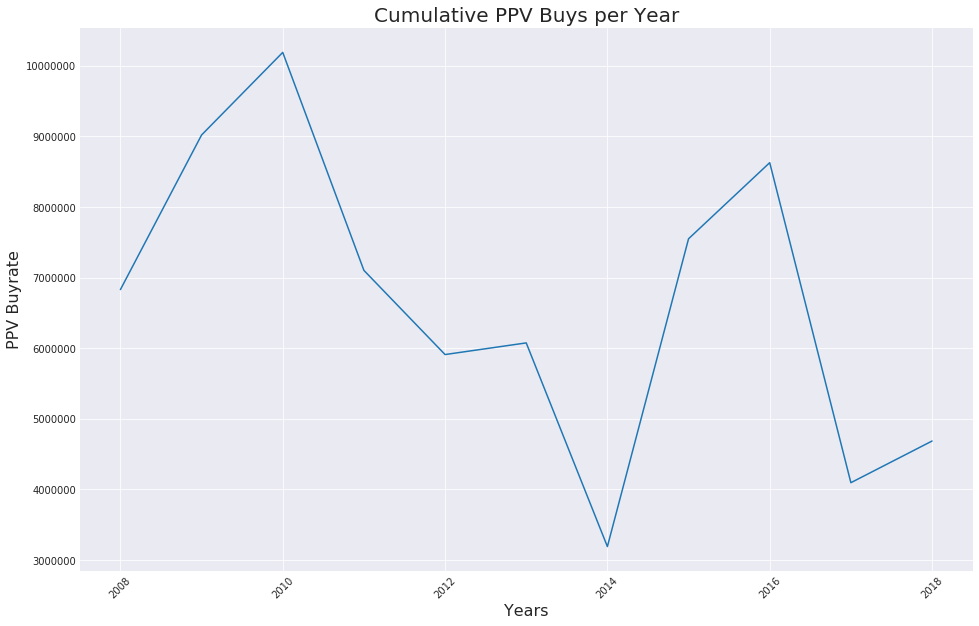

In [9]:
yearly_ppv_sum = ufc10.resample('Y')['Buyrate'].sum()
years = yearly_ppv_sum.index.year

plt.figure()
plt.plot(years, yearly_ppv_sum.values)

plt.ticklabel_format(style="plain")
#plt.xticks(years)
plt.xlabel("Years", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("PPV Buyrate", fontsize=16)
plt.title("Cumulative PPV Buys per Year", fontsize=20)
plt.savefig("images/1.png")

### Average Buyrate and Standard Deviation

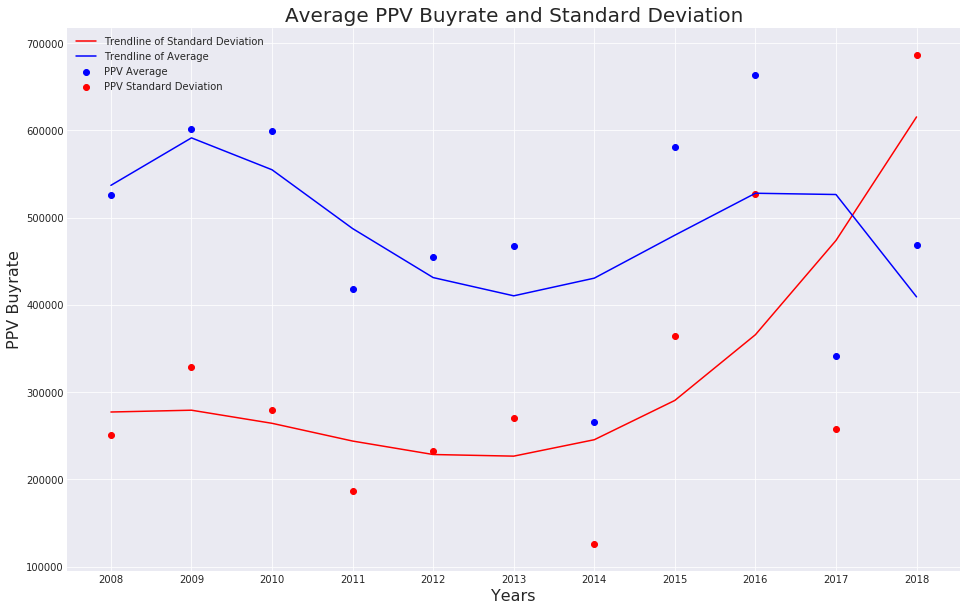

In [10]:
yearly_ppv_avg = ufc10.resample('Y')['Buyrate'].mean()
yearly_ppv_std = ufc10.resample('Y')['Buyrate'].std()

# polyfit to avg.

x = years
y_avg = yearly_ppv_avg.values
z_avg = np.polyfit(x, y_avg, 4) # 4th degree poly
p_avg = np.poly1d(z_avg)



# polyfit to std.
x = years
y_std = yearly_ppv_std.values
z_std = np.polyfit(x, y_std, 4) # 4th degree poly
p_std = np.poly1d(z_std)

plt.figure()

plt.plot(x, p_std(x), label='Trendline of Standard Deviation', c='r')
plt.plot(x, p_avg(x), label='Trendline of Average', c='b')
plt.scatter(years, yearly_ppv_avg, label='PPV Average', c='b')
plt.scatter(years, yearly_ppv_std, label='PPV Standard Deviation', c='r')


plt.xticks(years)
plt.legend()
plt.title('Average PPV Buyrate and Standard Deviation', fontsize=20)
plt.ylabel("PPV Buyrate", fontsize=16)
plt.xlabel("Years", fontsize=16)
plt.savefig('images/9.png')

The UFC's growing PPV volatility is easily seen by looking at its standard deviaton. While the average PPV buyrate was falling prior to 2015, the standard deviation remained fairly steady around 250,000 buys until 2014. After 2014 both begin to trend upwards - while the average quickly dips back down due to a relatively weak 2017 and 2018 (so far), UFC 229's all-time-high PPV has kept the standard deviation trending up.

The standard deviation is a measure of consistency in the data; ideally, the UFC should want the yearly PPV average to increase while its standard deviation stays low. This would mean consistently high PPV buyrates, and a reliable boatload of cash.

The fact that standard deviation is increasing suggests that the public is mostly interested in tuning in for super fights (e.g. Conor vs. Nate, Conor vs. Khabib). Not an entirely shocking revelation, but it does mean that the UFC needs to keep cultivating superstars to keep their numbers up. 

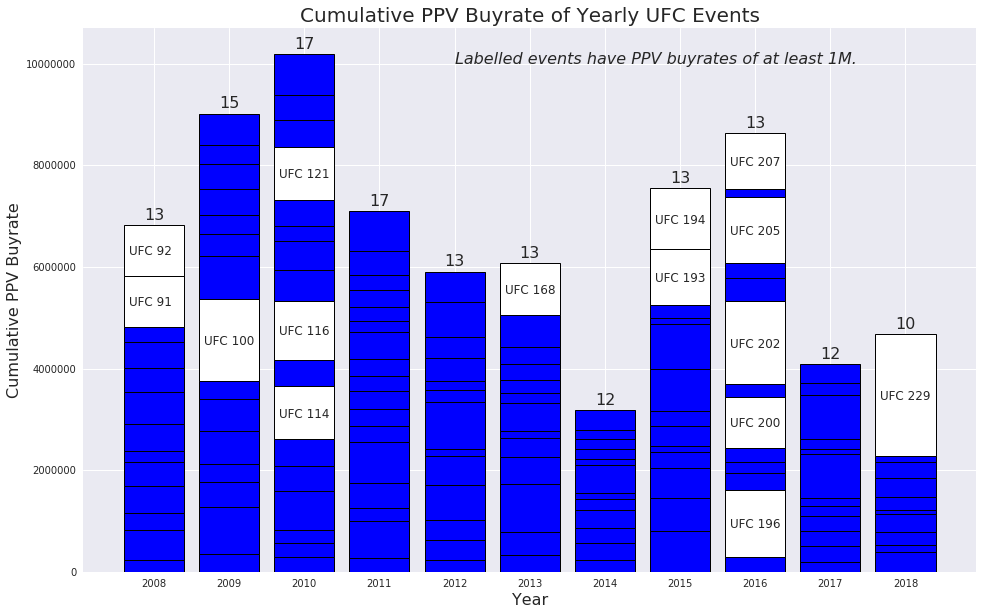

In [11]:
plt.figure()
sns.set()

plt.ticklabel_format(style='plain', axis='y')
for year in years:
    df = ufc10[str(year)]
    last = 0
    for buyrate, event in zip(df['Buyrate'], df['Event']):

        #if buyrate / df['Buyrate'].sum() > 0.1:
        if buyrate >= 1000000:
            plt.bar(year, buyrate, color='w', bottom=last, edgecolor='k', linewidth=1)
            plt.annotate(event,
                         xy=(year, last + buyrate/2),
                         xycoords='data',
                         xytext=(-25, -5),
                         textcoords='offset points', fontsize=12)
        else:
            plt.bar(year, buyrate, color='b', bottom=last, edgecolor='k', linewidth=1)

            
        last += buyrate
    plt.annotate(str(len(df)), xy=(year, last + 100000),
                 xycoords='data',
                 xytext=(-10, 0),
                 textcoords='offset points', fontsize=16)
    

plt.xticks(years)
plt.title('Cumulative PPV Buyrate of Yearly UFC Events', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Cumulative PPV Buyrate', fontsize=16)
plt.text(2012, 10000000, 'Labelled events have PPV buyrates of at least 1M.',
         fontsize=16, fontstyle='italic')
plt.savefig('images/2.png')

In [12]:
ufc10[ufc10['Buyrate'] == ufc10['Buyrate'].min()]

,Event,Title,Fighter_1,Fighter_2,Rematch,Venue,City,Attendance,Gate,Buyrate
Date,,,,,,,,,,
2018-05-12,UFC 224,Nunes vs. Pennington,Nunes,Pennington,0,Jeunesse Arena,"Rio de Janeiro, Brazil",10696.000,nan,85000.000


In [13]:
len(ufc10[ufc10['Buyrate'] >= 1000000]) / len(ufc10)

0.10135135135135136

The cumulative PPV Buyrate provides the clearest picture of the UFC's performance over time. In this barplot, each year's bar is the stacked sum of blocks representing all the events that occurred. Events that had PPV buys of at least 1M are labelled and in white; for a height reference, UFC 92 had exactly 1M reported buys.

The UFC's biggest PPV years are best exemplified in 2009, 2010, 2015, and 2016, where the bars are stacked with many tall blocks. 2009 and 2010 also had the added benefit of having a higher number of events, with 15 and 17 in each year respectively. Conversely, weak years like 2014 and 2017 are just small stacks of sliver PPV events. 2018 has so far been a year of extremes, featuring both the worst performing PPV event (UFC 224 at a measly 85,000 buys) as well as the best (UFC 229 with an estimated 2.4 million).

While choosing 1M PPV as a cutoff can seem a little bit arbitrary (many large PPVs come close to this at 800-900+), it does help illustrate an important point. In just the three year span of 2015-2018, the UFC has totalled more 1M+ events (8) than in the seven years prior (7). Only 10% of all events between 2008-2018 have met or surprassed 1M+ buys.

### Top PPV Event per Year

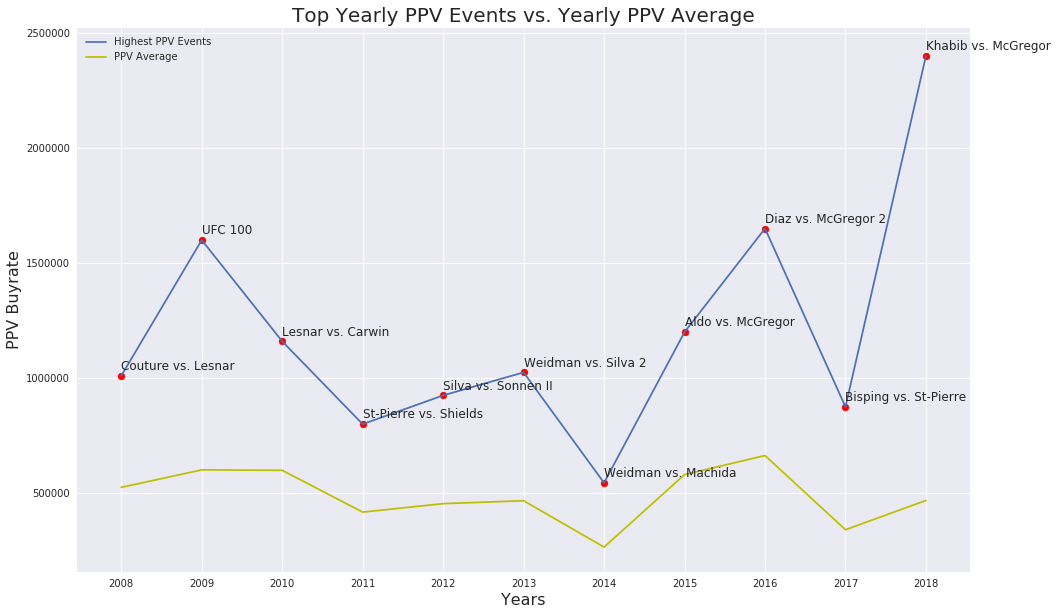

In [14]:
yearly_ppv_max = ufc10.resample('Y')['Buyrate'].max()

plt.figure()

plt.plot(years, yearly_ppv_max.values, label="Highest PPV Events")
plt.scatter(years, yearly_ppv_max.values, c='r')
plt.plot(years, yearly_ppv_avg.values, c='y', label="PPV Average")


for year in years:
    top_event = ufc10[str(year)][['Event', 'Title','Buyrate']].sort_values(by='Buyrate', ascending=False).iloc[0]
    plt.annotate(top_event['Title'], (year, top_event['Buyrate'] + 25000))

plt.legend()
plt.title("Top Yearly PPV Events vs. Yearly PPV Average", fontsize=20)
plt.xticks(years)
plt.xlabel("Years", fontsize=16)
plt.ylabel("PPV Buyrate", fontsize=16)
plt.savefig("images/3.png")

In [15]:
rematches = ufc10.loc[ufc10['Rematch'] == 1]
yearly_rematch_ppv_avg = rematches.resample('Y')['Buyrate'].mean().values
yearly_rematch_count = rematches.resample('Y')['Buyrate'].count()
delta = yearly_rematch_ppv_avg - yearly_ppv_avg

pos = delta.copy()
neg = delta.copy()

pos[pos <= 0] = np.nan
neg[neg > 0] = np.nan

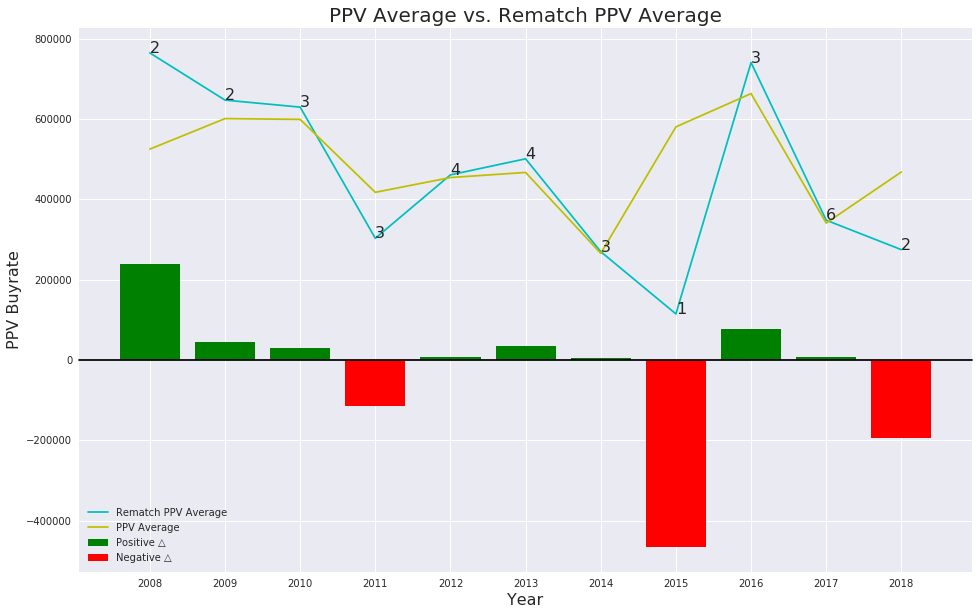

In [16]:
plt.figure()
sns.set()


plt.plot(years, yearly_rematch_ppv_avg, c='c', label="Rematch PPV Average")
plt.plot(years, yearly_ppv_avg.values, c='y', label="PPV Average")

for year, buy_avg in zip(years, yearly_rematch_ppv_avg):
    plt.annotate(yearly_rematch_count[str(year)][0], (year, buy_avg), fontsize=16)

plt.bar(years, pos, color='g', label="Positive △")
plt.bar(years, neg, color='r', label="Negative △")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Rematch Average relative to Yearly Average")

plt.legend()

plt.title("PPV Average vs. Rematch PPV Average", fontsize=20)
plt.ylabel("PPV Buyrate", fontsize=16)
plt.xticks(years)
plt.xlabel("Year", fontsize=16)
plt.savefig("images/4.png")

In [17]:
rematches['2018']

,Event,Title,Fighter_1,Fighter_2,Rematch,Venue,City,Attendance,Gate,Buyrate
Date,,,,,,,,,,
2018-06-09,UFC 225,Whittaker vs. Romero 2,Whittaker,Romero,1,United Center,"Chicago, Illinois",18117.000,2550000.000,250000.000
2018-08-04,UFC 227,Dillashaw vs. Garbrandt 2,Dillashaw,Garbrandt,1,Staples Center,"Los Angeles, California",17794.000,2850000.000,300000.000


In [18]:
# rematches = ufc10.loc[ufc10['Rematch'] == 1]
# yearly_rematch_ppv_avg = rematches.resample('Y')['Buyrate'].mean()

# plt.figure(figsize=(16, 10))

# plt.plot(years, yearly_rematch_ppv_avg.values, label="Rematch PPV Average")
# plt.plot(years, yearly_ppv_avg.values, c='g', label="PPV Average")

# plt.xlabel("Years")
# plt.xticks(rotation=45)
# plt.ylabel("PPV Buyrate")

# plt.legend()
# plt.title("PPV Average vs. Rematch PPV Average")
# plt.savefig("images/3.png")

In [19]:
round(yearly_rematch_ppv_avg / yearly_ppv_avg - 1, 2)

Date
2008-12-31    0.460
2009-12-31    0.080
2010-12-31    0.050
2011-12-31   -0.270
2012-12-31    0.010
2013-12-31    0.070
2014-12-31    0.020
2015-12-31   -0.800
2016-12-31    0.120
2017-12-31    0.020
2018-12-31   -0.410
Freq: A-DEC, Name: Buyrate, dtype: float64

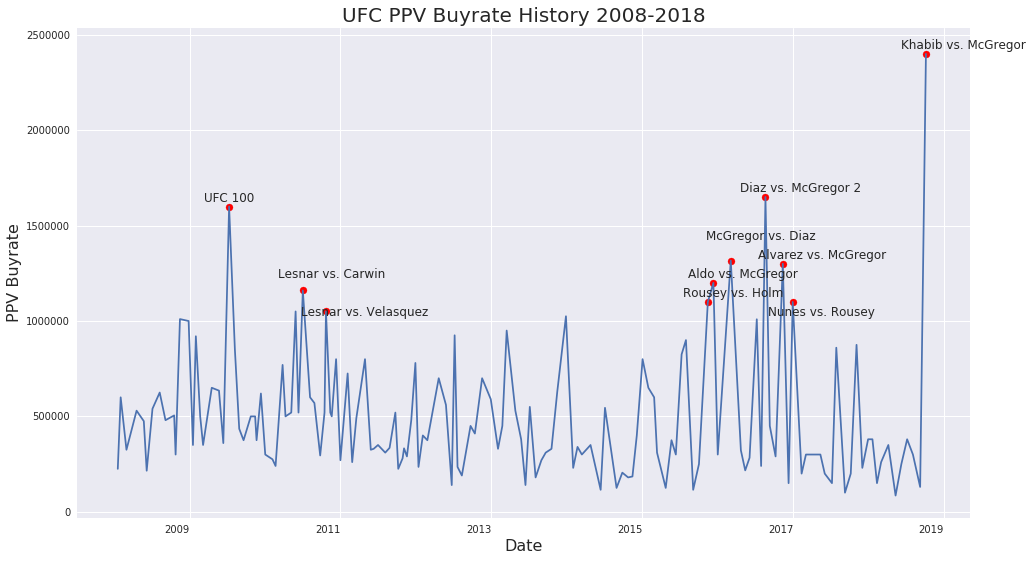

In [20]:
plt.figure()
ufc10['Buyrate'].plot()
top10_fights = ufc10.sort_values('Buyrate', ascending=False)[:10]
plt.scatter(top10_fights.index, top10_fights['Buyrate'], c='r')

y_vals = [2400000,1650000,1600000,1400000,1300000,1200000,1200000,1000000,1100000,1000000] 
for i, y in zip(top10_fights.index, y_vals):
    plt.annotate(ufc10.at[i, 'Title'], xy=(i, y),xycoords='data',
                 xytext=(-25, 5),
                 textcoords='offset points')

plt.title('UFC PPV Buyrate History 2008-2018', fontsize=20)
plt.ylabel("PPV Buyrate", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.xticks(rotation=0)

plt.savefig("images/5.png")

Looking at every PPV event's buyrate plotted over time, the first thing that jumps out to me here is just how much spikey the timeline is. There are only two times in this entire 10 year period where the UFC had two 1M+ events back-to-back: once in 2009 (UFC 93 and UFC 94) and again in late 2015 (UFC 193 and 194). Interestingly, exactly 100 other numbered UFC events happened between these two points. There is no consistent rise in PPV buys; almost every major event is bookended with two mediocre ones in the mid to low 250,000 buy range.

The top ten PPV events of all time are labelled by their title fighters. Two things stand out to me here; first, it seems to be a pretty exclusive club of repeat fighters. Conor McGregor last five fights have all made it to the top ten, and his recent mauling from Khabib Nurmagomedov has blown everything else out of the water as the most successful UFC event of all time. Besides Conor, the three other superstars here are Ronda Rousey, Nate Diaz, and Brock Lesnar, who have all established themselves to be huge event draws at one time or another. The fact that every top 10 event (besides the centennial) has one of these repeat fighters shows the huge financial benefit that these PPV unicorns have for the UFC.

Second, seven of the top ten events all occurred after 2015 and into the present. This recent surge in massive PPV numbers suggests to me that the UFC has been successful in breaking into the mainstream. Beginning with Rousey's reign as the first female superstar and transitioning into McGregor's career as Ireland's trash talking savior, the anticipation for massive fight nights has been palpable up here in Toronto, Canada.

If Conor's 2017 money fight with Floyd was taken into account here, there would be an even stronger case here that each of the UFC's past few years has exceeded the last in terms of mega-PPV events. Even still, the ever-present dips in the plot still indicate that these are relatively few and far between over the course of a single year.

In [21]:
ufc10.sort_values('Buyrate', ascending=False)[:10]

,Event,Title,Fighter_1,Fighter_2,Rematch,Venue,City,Attendance,Gate,Buyrate
Date,,,,,,,,,,
2018-10-06,UFC 229,Khabib vs. McGregor,Khabib,McGregor,0,T-Mobile Arena,"Paradise, Nevada",20034.000,17200000.000,2400000.000
2016-08-20,UFC 202,Diaz vs. McGregor 2,Nate Diaz,McGregor,1,T-Mobile Arena,"Las Vegas, Nevada",15539.000,7700810.000,1650000.000
2009-07-11,UFC 100,UFC 100,NaN,NaN,0,Mandalay Bay Events Center,"Las Vegas, Nevada",10871.000,5101740.000,1600000.000
2016-03-05,UFC 196,McGregor vs. Diaz,McGregor,Nate Diaz,0,MGM Grand Garden Arena,"Las Vegas, Nevada",14898.000,8100000.000,1317000.000
2016-11-12,UFC 205,Alvarez vs. McGregor,Alvarez,McGregor,0,Madison Square Garden,"New York City, New York",20427.000,17700000.000,1300000.000
2015-12-12,UFC 194,Aldo vs. McGregor,Aldo,McGregor,0,MGM Grand Garden Arena,"Las Vegas, Nevada",16516.000,10006249.000,1200000.000
2010-07-03,UFC 116,Lesnar vs. Carwin,Lesnar,Carwin,0,MGM Grand Garden Arena,"Las Vegas, Nevada",12740.000,2053990.000,1160000.000
2016-12-30,UFC 207,Nunes vs. Rousey,Nunes,Rousey,0,T-Mobile Arena,"Las Vegas, Nevada",18533.000,4750000.000,1100000.000
2015-11-15,UFC 193,Rousey vs. Holm,Rousey,Holm,0,Etihad Stadium,"Melbourne, Australia",56214.000,6800000.000,1100000.000


In [45]:
fighter1 = ufc10.copy()
fighter1.insert(0, "Fighter", fighter1["Fighter_1"])

fighter2 = ufc10.copy()
fighter2.insert(0, "Fighter", fighter2["Fighter_2"])

fighters_df = pd.concat([fighter1, fighter2], sort=False).sort_index()
headline_fights = fighters_df['Fighter'].value_counts()
headline_rematches = fighters_df.groupby('Fighter')['Rematch'].sum().sort_values(ascending=False)
# cum_ppv = fighters_df.groupby('Fighter')['Buyrate'].sum().sort_values(ascending=False)

fighters = fighters_df.pivot_table(values=['Attendance', 'Buyrate', 'Gate'], index='Fighter')
fighters['Headline Fights'] = headline_fights
fighters['Headline Rematches'] = headline_rematches
# fighters['Cumulative PPV Buys'] = cum_ppv


In [46]:
fighters_df[fighters_df['Fighter'] == 'Miocic'].sort_index()

,Fighter,Event,Title,Fighter_1,Fighter_2,Rematch,Venue,City,Attendance,Gate,Buyrate
Date,,,,,,,,,,,
2016-05-14,Miocic,UFC 198,Werdum vs. Miocic,Werdum,Miocic,0,Arena da Baixada,"Curitiba, Brazil",45207.000,nan,217000.000
2016-09-10,Miocic,UFC 203,Miocic vs. Overeem,Miocic,Overeem,0,Quicken Loans Arena,"Cleveland, Ohio",18875.000,2600000.000,450000.000
2017-05-13,Miocic,UFC 211,Miocic vs dos Santos 2,Miocic,dos Santos,1,American Airlines Center,"Dallas, Texas",17834.000,2662645.000,300000.000
2018-01-20,Miocic,UFC 220,Miocic vs. Ngannou,Miocic,Ngannou,0,TD Garden,"Boston, Massachusetts",16015.000,2450000.000,380000.000
2018-07-07,Miocic,UFC 226,Miocic vs. Cormier,Miocic,Cormier,0,T-Mobile Arena,"Paradise, Nevada",17464.000,5677238.000,380000.000


In [47]:
fighters

,Attendance,Buyrate,Gate,Headline Fights,Headline Rematches
Fighter,,,,,
Akiyama,17133.000,520000.000,2560000.000,1,0
Aldo,13669.000,365000.000,4814466.333,7,2
Alvarez,20427.000,1300000.000,17700000.000,1,0
Bagautinov,13506.000,115000.000,nan,1,0
Barão,13811.000,226666.667,4100000.000,3,1
Belfort,15040.333,516666.667,2640333.333,3,0
Bigfoot,12380.000,380000.000,nan,1,1
Bisping,15287.200,494600.000,3222168.750,5,2
Bonnar,16844.000,410000.000,nan,1,0


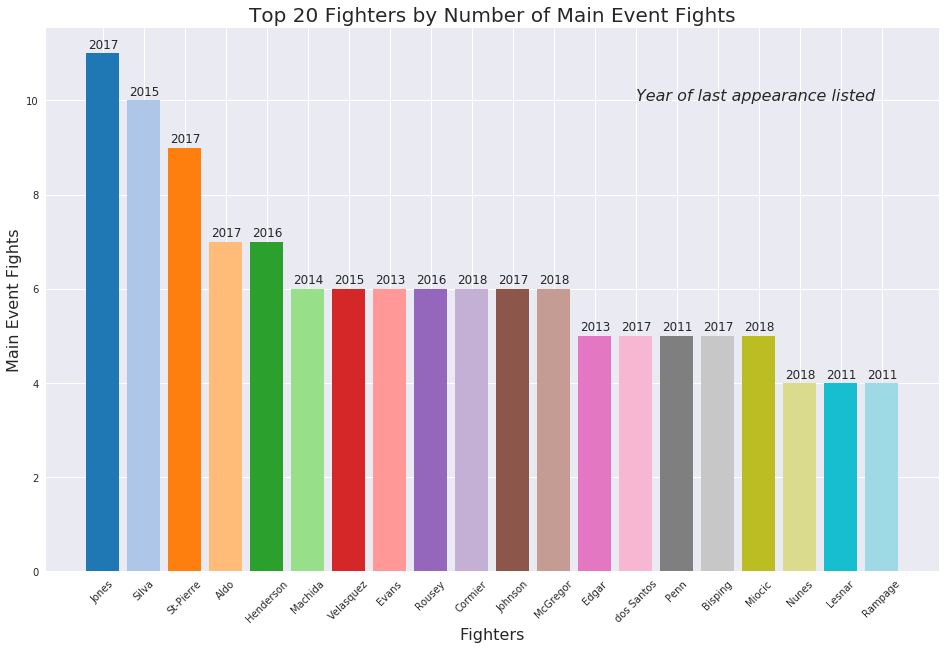

In [110]:
plt.figure()
plt.bar(headline_fights[:20].index, headline_fights[:20], color=sns.color_palette("tab20", 20))
plt.xticks(rotation=45)
plt.title("Top 20 Fighters by Number of Main Event Fights", fontsize=20)
plt.ylabel("Main Event Fights", fontsize=16)
plt.xlabel("Fighters", fontsize=16)
for i,x in zip(headline_fights[:20].index, headline_fights[:20].values):
    plt.annotate(fighters_df.loc[fighters_df['Fighter'] == i].iloc[-1].name.date().year, (i, x), rotation=0,
                    xycoords='data',
                     xytext=(-15, 5),
                 textcoords='offset points')

plt.annotate('Year of last appearance listed', xy=('dos Santos', 10), fontsize=16, fontstyle='italic')
plt.savefig("images/6.png")

In [85]:
len(fighters)

104

In [84]:
fighters['Headline Fights'].mean()

2.5576923076923075

Moving onto some statistics about the fighters themselves, I've plotted the top 20 fighters by their number of headline fight appearances. Jon Jones leads the pack at 11, with Anderson Silva and Georges St-Pierre following at 10 and 9 respectively. For the 104 unique headline fighters between UFC 80 in 2008 and UFC 229, the average number of headline fights is 2.55.

The last year each fighter appeared as a headliner is also listed. 

In [94]:
fighters[fighters.index == 'McGregor']

,Attendance,Buyrate,Gate,Headline Fights,Headline Rematches
Fighter,,,,,
McGregor,17238.833,1448666.667,11318117.833,6,1


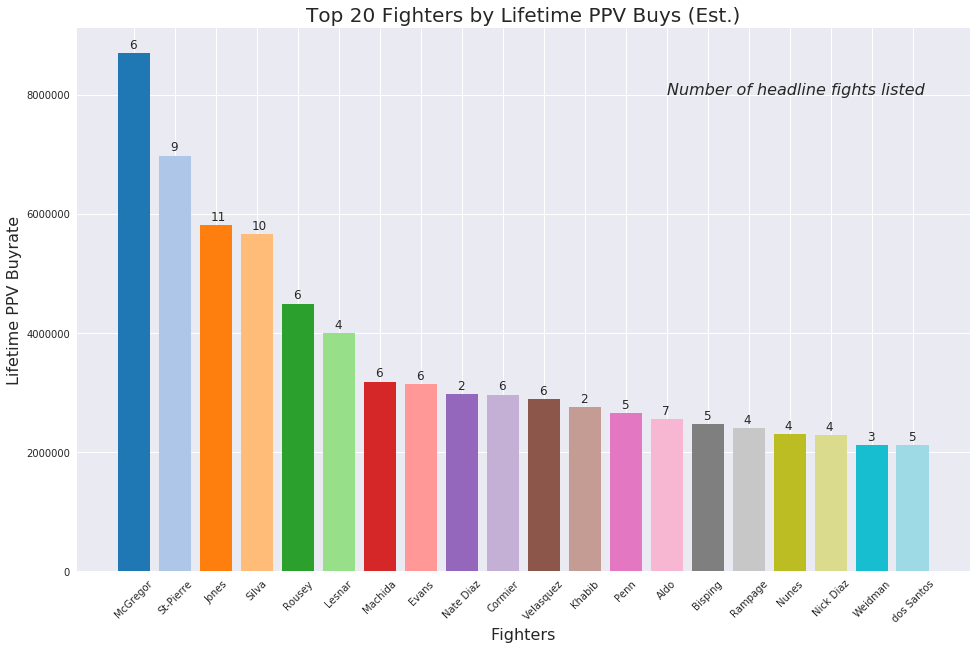

In [99]:
ppv_estimate = (fighters['Buyrate'] * fighters['Headline Fights']).sort_values(ascending=False)

#fig = plt.figure()
plt.bar(ppv_estimate[:20].index, ppv_estimate[:20], color=sns.color_palette("tab20", 20))
plt.ticklabel_format(style='plain', axis='y')
plt.title("Top 20 Fighters by Lifetime PPV Buys (Est.)", fontsize=20)
plt.ylabel("Lifetime PPV Buyrate", fontsize=16)
plt.xlabel("Fighters", fontsize=16)
plt.xticks(rotation=45)
for i,x in zip(ppv_estimate[:20].index, ppv_estimate[:20].values):
    plt.annotate(fighters.loc[fighters.index == i]['Headline Fights'][0], (i, x), rotation=0,
                    xycoords='data',
                     xytext=(-5, 5),
                 textcoords='offset points')

plt.annotate('Number of headline fights listed', xy=('Aldo', 8000000), fontsize=16, fontstyle='italic')
plt.savefig("images/7.png")

The barplot ranks all of the headline fighters by an estimate of their PPV buys they've brought in for the UFC (from 2008 to 2018). This estimate was calculated by averaging the PPV buyrates for each fighter based on the events they headlined, and multiplying it by the number of times they fought on cards as headline events. For example, although Eddie Alvarez's average as a headline event is over 1M+ PPV buys (due to facing Conor), he doesn't crack the top 20 in this list because he only headlined that single event.

I think this method provides a decent ranking of each fighter's worth to the UFC. With five of his six headline events surpassing over a million PPV buys, Conor McGregor easily takes the top spot as the UFC's biggest PPV cash cow. His encounters with both Khabib Nurmagomedov and Nate Diaz have propelled the both of them into the top 20, with each earning a wider fanbase seemingly bonded in a fierce dislike of McGregor. 

Georges St-Pierre, Jon Jones, and Anderson Silva, claim the next three spots due to their long, dominant runs as champions in their respective divisions. Following them are Ronda Rousey and Brock Lesnar, two (WWE) superstars who were able to bring in massive audiences with relatively less headline appearances.

It seems to me that the greatest return-on-income for the UFC might come from the fighters on this list who have less appearances, and more potential to evolve into even greater superstars in the future. The fact that fighters like Conor, Ronda, and Lesnar can place so highly with a lower number of fights speaks to the power of superfights to bring in crazy amounts of views. Examples of this in my mind are Khabib and Nate, who have proven themselves to be stone cold killers in their boughts against Conor. The potential return of Brock Lesnar to face Daniel Cormier (or even Jon Jones in a super steroid heavyweight bought) would certainly bring in massive views as well.

I would love to hear from others more informed than me on how accurate these PPV rankings seem, and if there's any way such a method for ranking these fighters could be improved!

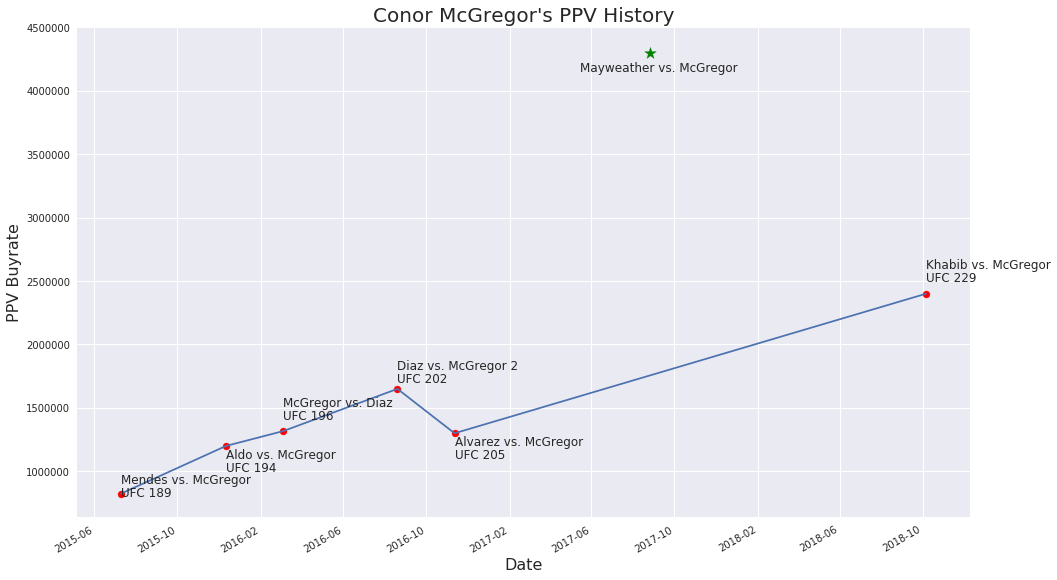

In [111]:
mcgregor = fighters_df.loc[fighters_df['Fighter'] == 'McGregor'].sort_index()

plt.figure()

mcgregor['Buyrate'].plot()
plt.scatter(mcgregor.index, mcgregor['Buyrate'], c='r')

plt.scatter('2017-08-26', 4300000, c='g', marker='*', s=150)
plt.annotate('Mayweather vs. McGregor', ('2017-05-15', 4150000))

y_vals = [900000, 1100000, 1510000, 1800000, 1200000, 2600000]
for i, y in zip(mcgregor.index, y_vals):
    plt.annotate(mcgregor.at[i, 'Title'], (i, y))
    plt.annotate(mcgregor.at[i, 'Event'], (i, y - 100000))

plt.ylabel('PPV Buyrate', fontsize=16)
plt.title("Conor McGregor's PPV History", fontsize=20)
plt.xlabel("Date", fontsize=16)

plt.savefig("images/8.png")

Conor McGregor has justified his worth and clout many times throughout this analysis, so I think it's fitting to see how his PPV trajectory has grown over time. Conor is a true outlier in MMA, with an unprecedented rise in popularity over the span of only three years. With only a single headline fight bringing in less than a million PPVs, and a single slight dip in views with his fight against Eddie Alvarez at UFC 205, I think I can safely say that he's been carrying the UFC financially over the past few years.

Conor's absence from the UFC in 2017 was severely felt in the company's cumulative PPV buys that year, but only because they invested so heavily in making the MayMac money fight the second most highly-viewed PPV event of all time. His fight against Khabib at UFC 229 surpassed his previous record rematching Nate Diaz at UFC 202 for the biggest UFC PPV event of all time.

Conor is the perfect representative for the UFC's current "superstar" era. After a lull

### Percentiles

In [29]:
# sorted_buyrates = ufc10['Buyrate'].sort_values()

# np.percentile(sorted_buyrates, 50)

377500.0

In [30]:
# perc_95 = ufc10.loc[ufc10.Buyrate >= np.percentile(sorted_buyrates, 95)]

# import pprint as pp

# pp.pprint([x for x in zip(perc_95['Title'], perc_95['Buyrate'])])

[('UFC 100', 1600000.0),
 ('Lesnar vs. Carwin', 1160000.0),
 ('Rousey vs. Holm', 1100000.0),
 ('Aldo vs. McGregor', 1200000.0),
 ('McGregor vs. Diaz', 1317000.0),
 ('Diaz vs. McGregor 2', 1650000.0),
 ('Alvarez vs. McGregor', 1300000.0),
 ('Nunes vs. Rousey', 1100000.0),
 ('Khabib vs. McGregor', 2400000.0)]
